In [51]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import (
    RandomForestClassifier, 
    AdaBoostClassifier, 
    StackingClassifier
)
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, 
    classification_report, 
    confusion_matrix, 
    ConfusionMatrixDisplay
)
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, Input
import keras
import keras_tuner as kt

In [52]:
df=pd.read_csv("train.csv",engine="python", delimiter=",") 
df_test=pd.read_csv("test.csv",engine="python",delimiter=",") 

In [53]:
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [54]:
df_test.isna().sum() 

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

<Axes: xlabel='Pclass', ylabel='Count'>

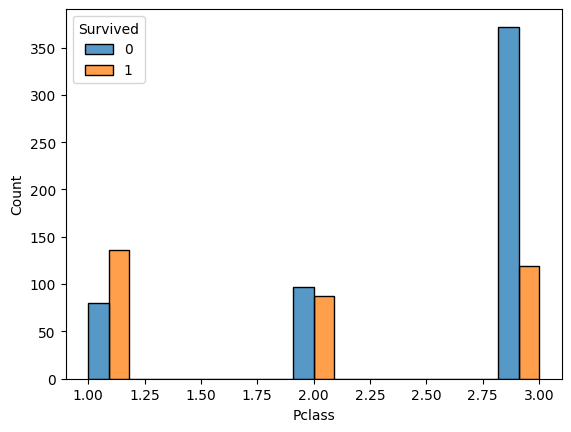

In [55]:
sns.histplot(data=df,x="Pclass",hue="Survived",multiple="dodge" ) 

In [56]:
df["Minor"]=df["Age"].apply(lambda x : 1 if x<18 else 0) 
df["Is.Senior"]=df["Age"].apply(lambda x : 1 if x>60 else 0) 
print("percentage of seniors:", sum(df["Is.Senior"])/df.shape[0] * 100)

print("percentage of survived in seniors:", df.loc[(df["Is.Senior"] == 1) & (df["Survived"] == 1)].shape[0]/df.loc[df["Is.Senior"]==1].shape[0]*100)

print("percentage of seniors:", sum(df["Minor"])/df.shape[0] * 100)

print("percentage of survived in minors:", df.loc[(df["Minor"] == 1) & (df["Survived"] == 1)].shape[0]/df.loc[df["Minor"]==1].shape[0]*100)


percentage of seniors: 2.4691358024691357
percentage of survived in seniors: 22.727272727272727
percentage of seniors: 12.682379349046016
percentage of survived in minors: 53.98230088495575


<Axes: xlabel='Fare', ylabel='Age'>

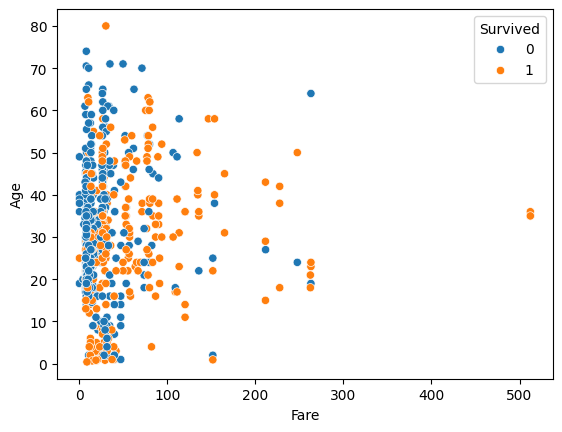

In [57]:
sns.scatterplot(data=df,x="Fare",y="Age",hue="Survived")

<Axes: xlabel='sum', ylabel='Count'>

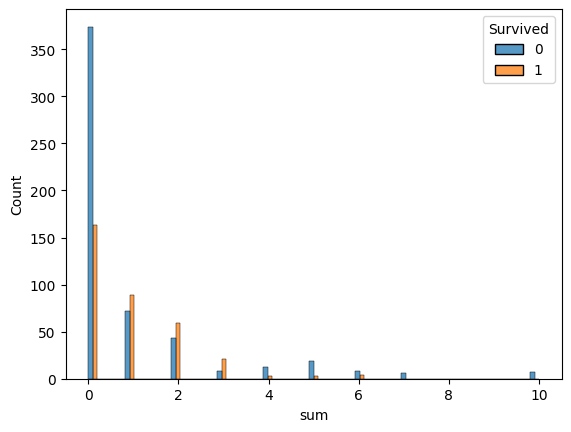

In [58]:
df["sum"]=df["SibSp"].to_numpy()+df["Parch"].to_numpy()
sns.histplot(data=df,x="sum",hue="Survived",multiple="dodge" ) 

<Axes: xlabel='Embarked', ylabel='Count'>

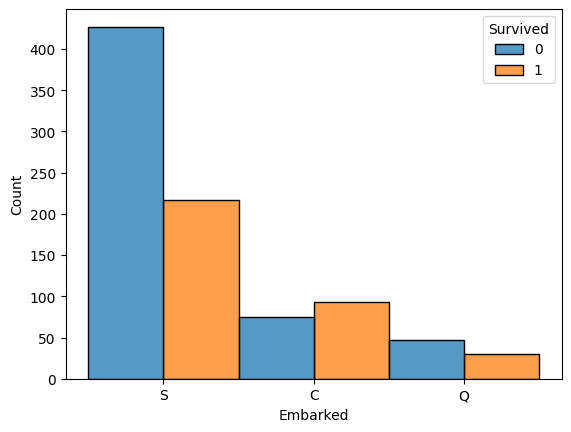

In [59]:
sns.histplot(data=df,x="Embarked",hue="Survived",multiple="dodge" ) 

<Axes: xlabel='Sex', ylabel='Count'>

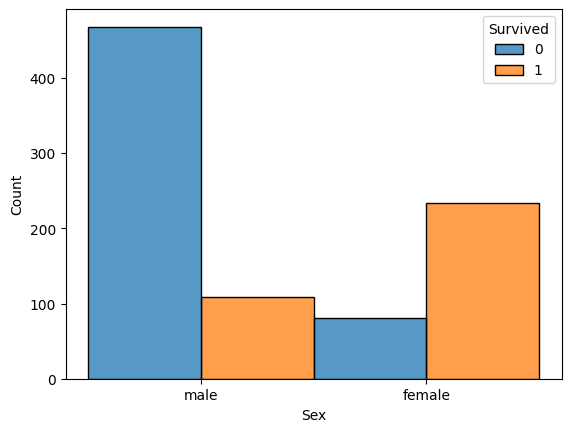

In [60]:
sns.histplot(data=df,x="Sex",hue="Survived",multiple="dodge" ) 

In [65]:
class FareTransformer(BaseEstimator,TransformerMixin): 
    def __init__(self): 
        pass   
    def fit(self, X, y=None):
        return self  
    def transform(self, X):
        df=X.copy()
        if "Fare" not in df.columns:
            raise ValueError("what are you doing man?")
        df["Fare"] = df["Fare"].fillna(df["Fare"].median())
        result=df["Fare"]
        result = (result - result.mean()) / result.std()
        return result.to_numpy().reshape(-1, 1).astype(float)

class FamilyMembersTransformer(BaseEstimator,TransformerMixin):
    def __init__(self): 
        pass   
    def fit(self, X, y=None):
        return self  
    def transform(self, X):
        df=X.copy()
        required_cols = ['SibSp', 'Parch']
        if not all(col in df.columns for col in required_cols):
            raise ValueError("what are you doing man?")
        result=df["SibSp"].to_numpy()+df["Parch"].to_numpy()
        result = (result - result.mean()) / result.std()
        return result.reshape(-1, 1)

        
class AgeTransfomer(BaseEstimator, TransformerMixin): 
    def __init__(self): 
        pass   
    def fit(self, X, y=None):
        return self  
    def transform(self, X):
        df=X.copy() 
        required_cols = ['Age', 'Sex', 'Pclass']
        if not all(col in df.columns for col in required_cols):
            raise ValueError("what are you doing man?")
        if  df["Age"].isna().sum()!=0: 
            df['Age'] = df['Age'].fillna(df.groupby(['Sex', 'Pclass'])['Age'].transform('median')) 
        df["Is.Minor"]=df["Age"].apply(lambda x : 1 if x<18 else 0) 
        df["Is.Senior"]=df["Age"].apply(lambda x : 1 if x>60 else 0) 
        Age_normalized = (df["Age"] - df["Age"].mean()) / df["Age"].std()

        OnehotAge_df = pd.concat([df[["Is.Minor"]], df[["Is.Senior"]]], axis=1)
        combined_df = pd.concat([Age_normalized, OnehotAge_df], axis=1)
        return combined_df.to_numpy()
class EmbarkedTransformer(BaseEstimator,TransformerMixin): 
    def __init__(self): 
        pass   
    def fit(self, X, y=None):
        return self  
    def transform(self, X):
        df=X.copy()
        if "Embarked" not in df.columns: 
            raise ValueError("what are you doing man?")
        if  df["Embarked"].isna().sum()!=0: 
            df["Embarked"]=df["Embarked"].fillna(df["Embarked"].transform('median'))
        result=pd.get_dummies(df["Embarked"], dtype=int) 
        return result.to_numpy().reshape(-1,1)
        
def CustomColumnTransformer(Numerical=["Pclass"],Categorical=["Sex"]):
        column_transformer = ColumnTransformer([
        ('age', AgeTransfomer(),['Age', 'Sex', 'Pclass']), 
        ("family",FamilyMembersTransformer(),['SibSp', 'Parch']),
        ("numerical",StandardScaler(),Numerical),
        ("numericalFare",FareTransformer(),["Fare"]),
        ("categorical", OneHotEncoder(drop='if_binary'),Categorical)], remainder='drop')
        return column_transformer

In [113]:


def XgBoost_Search(X,y): 
    trans=CustomColumnTransformer()
    trans.fit(X) 
    x=trans.transform(X)

   
    param_grid_xgb = {
        'n_estimators': [50, 100],  
        'learning_rate': [0.01],  
        'max_depth': [3,4,5], 
        'subsample': [0.7, 1.0],  
        'colsample_bytree': [ 1.0],  
        'gamma': [0], 
        'reg_lambda': [0.5,1]} 

    model=XGBClassifier()
    grid_search_xgb = GridSearchCV(model, param_grid_xgb, cv=5, scoring="accuracy", n_jobs=-1)
    grid_search_xgb.fit(x,y)
    best_params=grid_search_xgb.best_params_
    with open("Saved/XGBClassifier.json", "w") as f:
        json.dump(best_params, f, indent=4)    
    return  best_params

def Lightgbm_Search(X,y):
    param_grid_lgb = {
        'n_estimators': [200,300,400],
        'learning_rate': [0.01],
        'max_depth': [2,3],
        'subsample': [1],
        'colsample_bytree': [0.8],
        'min_split_gain': [0.1],   
        'reg_lambda': [3,4], 
        'is_unbalance':[True] }

    trans=CustomColumnTransformer()
    trans.fit(X) 
    x=trans.transform(X)

    model=LGBMClassifier()
    grid_search_lgb = GridSearchCV(model, param_grid_lgb, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search_lgb.fit(x,y)
    best_params=grid_search_lgb.best_params_
    with open("Saved/LGBMClassifier.json", "w") as f:
        json.dump(best_params, f, indent=4)
    return  best_params



def Ada_Search(X,y) : 
    trans=CustomColumnTransformer()
    trans.fit(X) 
    x=trans.transform(X)
    
    param_grid_ada = {
    'n_estimators': [100,200,300], 
    'learning_rate': [0.6,0.3], 
    'estimator': [DecisionTreeClassifier(max_depth=2), 
                          DecisionTreeClassifier(max_depth=3)]
    }
    model=AdaBoostClassifier()
    grid_search_ada = GridSearchCV(model, param_grid_ada, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search_ada.fit(x,y)
    best_params=grid_search_ada.best_params_
    serializable_params = {k: str(v) for k, v in best_params.items()}
    with open("Saved/AdaBoost.json", "w") as f:
        json.dump(serializable_params, f, indent=4)
    return best_params

def RF_Search(X,y):
    trans=CustomColumnTransformer()
    trans.fit(X) 
    x=trans.transform(X)
    param_grid_rf = {
    'n_estimators': [30,50,80,100],
    'max_depth': [3,4],
    'class_weight': ['balanced'], 
    'max_features': ['sqrt','log2']
    }
    model=RandomForestClassifier()
    grid_search_rf = GridSearchCV(model, param_grid_rf, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search_rf.fit(x,y)
    best_params=grid_search_rf.best_params_
    with open("Saved/RandomForest.json", "w") as f:
        json.dump(best_params, f, indent=4)  
    return grid_search_rf
def KNN_Search(X, y):
    trans = CustomColumnTransformer()  
    trans.fit(X)
    x = trans.transform(X)
    

    param_grid_knn = {
        'n_neighbors': [3],
        'weights': ['uniform', 'distance']
    }
    model = KNeighborsClassifier()
    

    grid_search_knn = GridSearchCV(model, param_grid_knn, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search_knn.fit(x, y)

    best_params = grid_search_knn.best_params_
    with open("Saved/KNN.json", "w") as f:
        json.dump(best_params, f, indent=4)
    
    return grid_search_knn
    
def SVM_Search(X, y):
    trans = CustomColumnTransformer()
    trans.fit(X)
    x = trans.transform(X)
 
    param_grid_svm = {
        'C': [6, 10,15],
        'kernel': ['rbf'],
        'gamma': ['auto']
    }
    
 
    model = SVC()
    

    grid_search_svm = GridSearchCV(model, param_grid_svm, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search_svm.fit(x, y)
    

    best_params = grid_search_svm.best_params_
    with open("Saved/SVM.json", "w") as f:
        json.dump(best_params, f, indent=4)
    
    return grid_search_svm
def GetModel(model):
    transformer=CustomColumnTransformer()
    model_pipeline=Pipeline([
        ("transformer",transformer),
        ("model",model)])
    return model_pipeline

def TestModel(model,x_train,x_test,y_train,y_test): 
    model_pipeline=GetModel(model)
    model_pipeline.fit(x_train,y_train) 
    y_pred=model_pipeline.predict(x_test)
    print("Classification Report:\n", classification_report(y_test, y_pred))
    return model_pipeline

def StackingSearch(model1,model2,model3,x,y):
    estimators = [
        ('model1', GetModel(model1)),
        ('model2', GetModel(model2)),
        ('model3', GetModel(model3))
    ]
    
    stacking_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression()
    )

    param_grid = {
    'final_estimator__C': [0.01,0.1],
    'final_estimator__penalty': ['l2']
    }

    grid_search = GridSearchCV(stacking_clf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X, y)

    best_params = grid_search.best_params_
    with open("Saved/Stacking.json", "w") as f:
        json.dump(best_params, f, indent=4)
    return best_params


def EnsambleModel(model1,model2,model3,x_train,x_test,y_train,y_test):
    estimators = [
        ('model1', GetModel(model1)),
        ('model2', GetModel(model2)),
        ('model3', GetModel(model3))
    ]
    meta_model = LogisticRegression(C=0.01,penalty='l2') 
    stacking_clf = StackingClassifier(estimators=estimators, final_estimator=meta_model, cv=5)
    stacking_clf.fit(x_train, y_train)
    y_pred=stacking_clf.predict(x_test)
    print("Classification Report:\n", classification_report(y_test, y_pred))
    return stacking_clf,y_pred


In [114]:
target_col="Survived"
X = df.drop(columns=[target_col],axis=1) 
y = df[target_col]
X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)


In [115]:
# KNN_Search(X,y) 
# RF_Search(X,y)
# Ada_Search(X,y)
#Lightgbm_Search(X,y)
#XgBoost_Search(X,y)
#SVM_Search(X, y)

GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [6, 10, 15], 'gamma': ['auto'],
                         'kernel': ['rbf']},
             scoring='accuracy')

In [110]:

TestModel(LGBMClassifier(colsample_bytree=0.8, 
                        is_unbalance=True,
                        learning_rate=0.01,
                        max_depth=2, 
                        min_split_gain=0.1, 
                        n_estimators=400, 
                        reg_lambda=3, 
                        subsample=1),
          X, X_test, y, y_test)
TestModel(XGBClassifier(colsample_bytree=1, 
                        max_depth=4, 
                        learning_rate=0.01, 
                        n_estimators=100, 
                        reg_lambda=1, 
                        gamma=0,
                        subsample=0.7),
          X, X_test, y, y_test)
TestModel(KNeighborsClassifier(n_neighbors=3,weights='uniform'),
          X, X_test, y, y_test)
TestModel(AdaBoostClassifier(n_estimators=200,learning_rate=0.6,estimator=
                            DecisionTreeClassifier(max_depth=2)),
          X, X_test, y, y_test)
TestModel(RandomForestClassifier(n_estimators=80,max_features='log2',
                                 class_weight='balanced',max_depth=5),
          X, X_test, y, y_test)
TestModel(SVC(gamma='auto',C=10,kernel='rbf'),
          X, X_test, y, y_test)

C:\Users\Ricardo\Programming\PycharmProjects\ML_Intro-Projects\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.85      0.83       110
           1       0.74      0.67      0.70        69

    accuracy                           0.78       179
   macro avg       0.77      0.76      0.77       179
weighted avg       0.78      0.78      0.78       179

Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.98      0.85       110
           1       0.94      0.46      0.62        69

    accuracy                           0.78       179
   macro avg       0.84      0.72      0.73       179
weighted avg       0.82      0.78      0.76       179

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.85      0.82       110
           1       0.73      0.67      0.70        69

    accuracy                           0.78       179
   macro avg       0.77      0.76      0.76       179
we

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('age', AgeTransfomer(),
                                                  ['Age', 'Sex', 'Pclass']),
                                                 ('family',
                                                  FamilyMembersTransformer(),
                                                  ['SibSp', 'Parch']),
                                                 ('numerical', StandardScaler(),
                                                  ['Pclass']),
                                                 ('numericalFare',
                                                  FareTransformer(), ['Fare']),
                                                 ('categorical',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['Sex'])])),
                ('model', SVC(C=10, gamma='auto'))])

In [111]:
#StackingSearch(SVC(gamma='auto',C=10,kernel='rbf'),RandomForestClassifier(n_estimators=80,max_features='log2',
                            #      class_weight='balanced',max_depth=5),AdaBoostClassifier(n_estimators=200,learning_rate=0.6,estimator=
                            # DecisionTreeClassifier(max_depth=2)),X,y)


{'final_estimator__C': 0.01, 'final_estimator__penalty': 'l2'}

In [123]:
FinalModel,a=EnsambleModel(SVC(gamma='auto',C=10,kernel='rbf'),RandomForestClassifier(n_estimators=80,max_features='log2',
                                 class_weight='balanced',max_depth=5),AdaBoostClassifier(n_estimators=200,learning_rate=0.6,estimator=
                            DecisionTreeClassifier(max_depth=2)),X, X_test, y, y_test)

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.93      0.86       110
           1       0.85      0.65      0.74        69

    accuracy                           0.82       179
   macro avg       0.83      0.79      0.80       179
weighted avg       0.82      0.82      0.82       179



## FINAL MODEL

In [125]:
X = df.drop(columns=[target_col],axis=1) 
y = df[target_col]
FinalModel.fit(X,y)
X = df_test
y_final=FinalModel.predict(X)

In [126]:
Ids=df_test['PassengerId'].values
output=pd.DataFrame({'PassengerId': Ids.ravel() ,
                     'Survived':y_final.ravel()})
output.to_csv('submission.csv',index=False)


## NN approach

In [154]:
def build_keras_functional_model(input_shape):
    inputs = Input(shape=(input_shape,)) 
    x = layers.Dense(16, activation='relu')(inputs)
    x = layers.Dense(8, activation='relu')(x)
    outputs = layers.Dense(1, activation='sigmoid')(x) 
    model = models.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [155]:
target_col="Survived"
X = df.drop(columns=[target_col],axis=1) 
y = df[target_col]
transfomer=CustomColumnTransformer()
transfomer.fit(X) 
x=transfomer.transform(X)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42,stratify=y)





In [156]:
model=build_keras_functional_model(x.shape[1]) 
callbacks_list = [
    keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=3)
    # ),
    # keras.callbacks.ModelCheckpoint(
    #     filepath="checkpoint_path.keras",
    #     monitor="val_loss",
    #     save_best_only=True
    # )
]

In [157]:
model.fit(X_train,y_train,
            epochs=20,batch_size=64,  
             validation_data=(X_test, y_test),callbacks= callbacks_list)
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

Epoch 1/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.3600 - loss: 0.7277 - val_accuracy: 0.5810 - val_loss: 0.7079
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5350 - loss: 0.7147 - val_accuracy: 0.6704 - val_loss: 0.6963
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6380 - loss: 0.6921 - val_accuracy: 0.6816 - val_loss: 0.6877
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6850 - loss: 0.6848 - val_accuracy: 0.6872 - val_loss: 0.6800
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7437 - loss: 0.6757 - val_accuracy: 0.6927 - val_loss: 0.6731
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7414 - loss: 0.6674 - val_accuracy: 0.7095 - val_loss: 0.6659
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7611 - loss: 0.6519 - val_accuracy: 0.7374 - val_loss: 0.6575
Epoch 8/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7620 - loss: 0.6435 - val_accuracy: 0.7542 - val_los

In [166]:

def build_model(hp, inputShape):
    inputs = tf.keras.Input(shape=(inputShape,))
    x = layers.Dense(
        units=int(hp.get('units')),
        activation='relu',
        kernel_regularizer=regularizers.l1_l2(
            l1=hp.get('l1'),
            l2=hp.get('l2')
        )
    )(inputs)
    
    for i in range(int(hp.get('num_layers'))):
        x = layers.Dense(
            units=int(hp.get('units')),
            activation='relu', 
            kernel_regularizer=regularizers.l1_l2(
                l1=hp.get('l1'),
                l2=hp.get('l2')
            )
        )(x)
        x = layers.Dropout(rate=float(hp.get('dropout_rate')))(x)
    
    outputs = layers.Dense(1, activation='sigmoid')(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=hp.Float('learning_rate', min_value=0.001, max_value=0.01, step=0.002)
        ),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model


In [167]:
callbacks_list = [
    keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=3
    ),
    keras.callbacks.ModelCheckpoint(
        filepath="checkpoint_path.keras",
        monitor="val_loss",
        save_best_only=True
    )
]

In [168]:

def NNSearch(rounds,X_train,y_train_np):
    k = 5  
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    trial_results = {}

    for trial in range(rounds):
        trial_hps = kt.HyperParameters()
        trial_hps.Int('units', min_value=8, max_value=24, step=8) 
        trial_hps.Int('num_layers', min_value=1, max_value=4)  
        trial_hps.Float('l1', min_value=0.0015, max_value=0.005, step=0.0005)  
        trial_hps.Float('l2', min_value=0.0015, max_value=0.005, step=0.0005)
        trial_hps.Float('dropout_rate', min_value=0.1, max_value=0.3, step=0.05)
        fold_accuracies = []
        model = build_model(trial_hps,X_train.shape[1])
        for fold, (train_idx, val_idx) in enumerate(kf.split(X_train, y_train_np)):
            X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
            y_train_fold, y_val_fold = y_train_np[train_idx], y_train_np[val_idx]
        
            model.fit(X_train_fold, y_train_fold, epochs=20, batch_size=16, verbose=0,
                  validation_data=(X_val_fold, y_val_fold),callbacks= callbacks_list)

            val_loss, val_acc = model.evaluate(X_val_fold, y_val_fold, verbose=0)
            fold_accuracies.append(val_acc)
        avg_accuracy = np.mean(fold_accuracies)
        print(f" Average Accuracy Across {k} Folds: {avg_accuracy:.4f}")
        trial_results[trial] = {'params': trial_hps.values, 'accuracy': avg_accuracy}


    best_trial = max(trial_results, key=lambda x: trial_results[x]['accuracy'])
    best_hps = trial_results[best_trial]['params']
    print(best_hps)
    return best_hps


In [169]:
NNSearch(10,x,y)

 Average Accuracy Across 5 Folds: 0.7677
 Average Accuracy Across 5 Folds: 0.8047
 Average Accuracy Across 5 Folds: 0.8137
 Average Accuracy Across 5 Folds: 0.7611
 Average Accuracy Across 5 Folds: 0.8047
 Average Accuracy Across 5 Folds: 0.8070
 Average Accuracy Across 5 Folds: 0.8103
 Average Accuracy Across 5 Folds: 0.7700


KeyboardInterrupt: 